# Milestone 2

### Recap: Statement of Problem

A restauranteur is planning to open a new restaurant specializing in vegan cuisine and would like to predict the success of new recipes created by the restaurant's chefs before they are served to the public. The restauranteur has hired a team of data scientists to develop a model to predict the success of new recipes based on ratings and reviews of existing recipes. The data scientists have obtained a data set from food.com (via kaggle.com) with recipes that have been rated and reviewed by the site's users. They now must determine the feasibility of developing a working model to predict the rating of a given recipe based on other attributes supplied in the data set. The initial goal is to develop a model that can predict a recipe's rating based attributes such as nutritional content, ingredients, visual characteristics, and a range of descriptive tags of recipes. A longer range goal is to perform sentiment analysis on the reviews. When the model is developed, the restaurant's chefs hope to be able to tweak the recipes they create to achieve higher ratings with the restaurant's guests and visiting food critics.

In this milestone we want to test whether certain categorical variables representing components of the recipes such as carbohydrate, fat, and sodium content have a meaningful effect on user ratings using classical (T-tests and ANOVA), bootstrap, and Bayesian methods.

### Preparation

Import required libraries:

In [59]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.stats.weightstats as ws
import sys

from matplotlib import pyplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import scale
from scipy.stats import kstest
from statistics import mean

Define global options:

In [60]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Display full array
np.set_printoptions(threshold=sys.maxsize)

Declare functions:

In [115]:
# Display kernel density plot for the given column with options
# Display box plot for the given column
def show_box_plot(df, col_name, axis, label):
    axis.boxplot(df.loc[:, col_name])
    axis.set_title('Box plot of ' + label) # Give the plot a main title
    axis.set_ylabel(label) # Set  text for y axis

def show_kde_plot(df, col_name, axis, bandwidth, label):
    sns.kdeplot(df.loc[:, col_name], ax = axis, bw = bandwidth)
    axis.set_title('KDE plot of ' + label) # Give the plot a main title
    axis.set_xlabel(label) # Set text for the x axis
    axis.set_ylabel('Density')# Set text for y axis

# The following functions are from DataScience410/Lecture4/HypothesisTesting_TestsOnMeans

# Perform a two-sided t-test on sample means with summary statistics
def t_test(a, b, alpha, alternative='two-sided', usevar = 'unequal'):
    '''Function to compute a two sample t-test on means'''
    
    ## Compute the difference in means for reporting.
    diff = a.mean() - b.mean()

    ## Compute the t-test
    t, p, df = ws.ttest_ind(a, b, usevar=usevar)
    
    ## Find the confidence interval
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar=usevar) 

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([df, diff, t, p, confint[0], confint[1]], index = index) 

# Compare differences of mean and distribution via histogram
def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

# Plot a histogram of frequency vs. value
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

# Plot histograms of means with confidence bounds shown
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

# The following functions are from DataScience410/Lecture4/HypothesisTesting_Distributions.ipynb

# Perform a Q-Q plot
def qq_plot(vec1, vec2):
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

# Perform a cumulative distribution plot
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')

# Perform a Kolmogorov-Smirnov Test
def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

# The following functions are from DataScience410/Lecture5/Bootstrap.ipynb

# Plot histograms of two samples with means and confidence intervals
def plot_hist(x, xmin, xmax, p=5, nbins=20):
    # Plot the distribution and mark the mean
    pyplot.hist(x, bins=nbins, alpha=.5)
    x_mean = x.mean() 
    pyplot.axvline(x_mean)
    print('Point estimate of the mean = %6.2f' %x_mean)
    # 95% confidence interval  
    upper_ci = np.percentile(x, 100-p/2.)
    lower_ci = np.percentile(x, p/2.)
    pyplot.axvline(upper_ci, color='red', linewidth=3)
    pyplot.axvline(lower_ci, color='red', linewidth=3)
    print('The lower and upper confidence intervals = %6.2f %6.2f \n' %(lower_ci,upper_ci))
    pyplot.xlim( xmin, xmax )

# Create distribution plots of two samples
def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    xmin = combined.min()
    xmax = combined.max()
    breaks = np.linspace(
        xmin, xmax, 
        num=nbins+1)

    pyplot.subplot(2, 1, 1)
    plot_hist(a, xmin, xmax)
    pyplot.title(a_label)
    
    pyplot.subplot(2, 1, 2)
    plot_hist(b, xmin = xmin, xmax = xmax)
    pyplot.title(b_label)
    
    pyplot.tight_layout()

# The following functions are from DataScience410/Lecture5/IntroductionToBayes.ipynb

# Compute posterior distribution
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

# Plot the posterior distribution
def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = nr.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')

    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))

# Compare groups via Bayesian model
def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

### Load the Data Set

Original source of the data set is https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions/version/2.

I have extracted vegan recipes from the original data set and cleaned the data in various ways as part of my milestone project for DATASCI 400 CS as well as the present milestone project:
- Removed recipes that are not vegan based on a string-based list of tags in the kaggle.com data set
- Removed recipes that contain non-vegan ingredients that were mis-tagged as vegan in the kaggle.com data set (e.g. chicken, eggs, dairy products, etc.)
- Removed desserts, breads, and other recipes that are not main courses, sides, soups, salads, and appetizer
- Removed recipes that are incomplete for serving in a restaurant, such as spice rubs, marinades
- Removed recipes with incomplete nutritional data
- Removed recipes with an insufficient number of user reviews (less than three)
- Added missing variables that are listed on the web site but not in the data set, for example, serving size and number of servings. These variables are crucial to make use of the nutritional information for comparisons but are missing in the kaggle.com data set. I have re-added these fields to the data set by scraping food.com web side and parsing the HTML for the proper fields.
- Created dichotomous variables for categorical data parsed from string-based lists in the kaggle.com data set

The new data set is https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data

In [62]:
# Internet location of the data set
url = 'https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data'

# Download the data into a dataframe object
recipes = pd.read_table(url)

### Summary Statistics

An overview of summary statistics for numeric attributes:

In [63]:
pd.options.display.float_format = '{:.4f}'.format
recipes[['n_ingredients', 'serving_size_g', 'n_servings', 'calories', 'calories_per_g', 
         'total_fat_pdv', 'total_fat_g', 'total_fat_pct', 'sugar_pdv', 'sugar_g', 
         'sugar_pct', 'sodium_pdv', 'sodium_g', 'sodium_pct', 'protein_pdv', 'protein_g', 
         'protein_pct', 'saturated_fat_pdv', 'saturated_fat_g', 'saturated_fat_pct', 
         'carbohydrates_pdv', 'carbohydrates_g', 'carbohydrates_pct', 'num_reviews', 
         'mean_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_ingredients,2968.0000,9.2426,3.7581,2.0000,7.0000,9.0000,12.0000,25.0000
serving_size_g,2968.0000,347.8851,806.7239,2.0000,124.0000,202.0000,326.2500,19215.0000
n_servings,2968.0000,5.0313,5.7899,1.0000,4.0000,4.0000,6.0000,192.0000
calories,2968.0000,263.9339,290.5454,0.1000,111.8000,195.6000,315.1000,4055.1000
calories_per_g,2968.0000,1.3029,1.3942,0.0009,0.5716,0.9560,1.5477,26.1984
total_fat_pdv,2968.0000,16.9869,35.0557,0.0000,3.0000,9.0000,20.0000,704.0000
total_fat_g,2968.0000,11.0415,22.7862,0.0000,1.9500,5.8500,13.0000,457.6000
total_fat_pct,2968.0000,0.0633,0.1336,0.0000,0.0078,0.0285,0.0679,2.8238
sugar_pdv,2968.0000,35.9693,101.5755,0.0000,7.0000,16.0000,33.0000,3162.0000
sugar_g,2968.0000,17.9847,50.7877,0.0000,3.5000,8.0000,16.5000,1581.0000


Summary statistics for the bootstrap and Bayesian methods are given below where applicable under the respective headings for these methods where we perform hypothesis tests and compute confidence intervals on the means.

### Identify Distributions of Features of Interest

In this milestone, we are examining the effect of three features on user ratings of recipes: carbohydrate content, fat content, and sodium content. Here we examine the distributions of the four relevant variables: Carbohydrates as percentage of serving mass, total fat as a percentage of serving mass, total sodium as a percentage of serving mass, and mean user rating.

We examine the distributions of these features using kernel density plots:

Text(0.5, 0.98, 'Distribution of Relevant Nutrients by Value and Percent Mass')

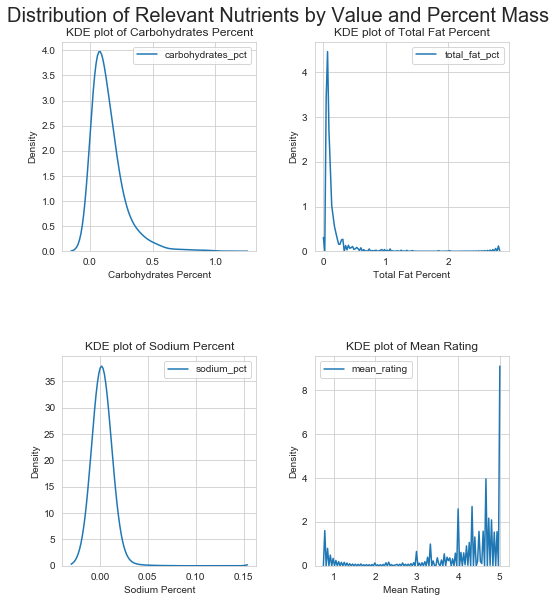

In [114]:
# Examine distributions of numeric columns via kernel density plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.5, top=0.92, bottom=0.01)
fig.suptitle('Distribution of Relevant Nutrients by Value and Percent Mass', fontsize='20')
sns.set_style("whitegrid")
show_kde_plot(recipes, 'carbohydrates_pct', ax1, 0.05, 'Carbohydrates Percent')
show_kde_plot(recipes, 'total_fat_pct', ax2, 0.0005, 'Total Fat Percent')
show_kde_plot(recipes, 'sodium_pct', ax3, 0.01, 'Sodium Percent')
show_kde_plot(recipes, 'mean_rating', ax4, 0.001, 'Mean Rating')

We examine the distributions of these features using box plots:

Text(0.5, 0.98, 'Distribution of Relevant Nutrients by Value and Percent Mass')

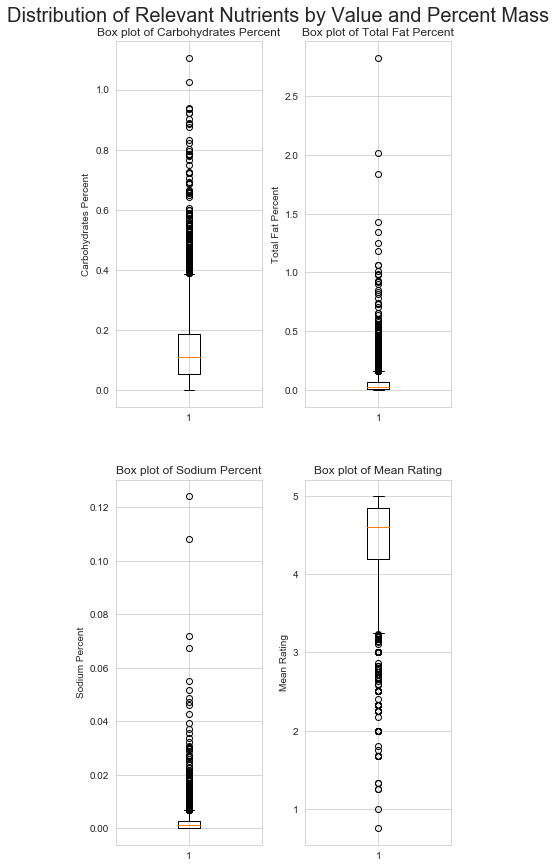

In [119]:
# Examine distributions of numeric columns via box plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.2, top=0.94, bottom=0.01)
fig.suptitle('Distribution of Relevant Nutrients by Value and Percent Mass', fontsize='20')
sns.set_style('whitegrid')
show_box_plot(recipes, 'carbohydrates_pct', ax1, 'Carbohydrates Percent')
show_box_plot(recipes, 'total_fat_pct', ax2, 'Total Fat Percent')
show_box_plot(recipes, 'sodium_pct', ax3, 'Sodium Percent')
show_box_plot(recipes, 'mean_rating', ax4, 'Mean Rating')

The distributions of carbohydrate percent, fat percent, and sodium percent are positively skewed. The distribution of the mean rating is negatively skewed.

### Identify the Distribution of User Ratings

We examine the distribution of *mean_rating* in detail because it is this feature that we would like to predict on the basis of other features, namely, carbohydrates, fat, and sodium. We construct new categorical variables for these other features by binning the numerical values by tertile (below), so their distribution is simply one third of all recipes. But the feature we want to predict, *mean_rating*, is a numeric value whose distribution we would like to analyze further.

#### Testing the Distribution of *mean_rating* and log(*mean_rating*)

First, perform normality tests via graphical methods using a Q-Q plot and a comparison plot of cumulative distribution functions on price and log(price). Then perform a formal Kolmogorov-Smirnov Test.

##### Graphical Method 1: Q-Q Plot

The Q-Q plot of *mean_rating*:

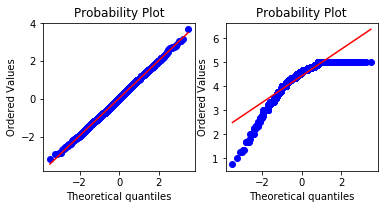

In [64]:
mean_rating = recipes.mean_rating

# generate a normal distribution for comparison
nr.seed(1357)
norm1 = nr.normal(size = len(mean_rating)).tolist()

# get 'mean_rating' column as array excluding undefined, zero, and negative values
mean_rating = np.array(recipes['mean_rating'].values)

# perform Q-Q plot of 'mean_rating'
qq_plot(norm1, mean_rating)

Clearly, we don't have a normal distribution for *mean_rating*.

The Q-Q plot of log(*mean_rating*):

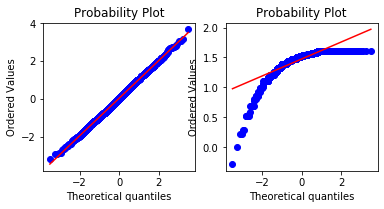

In [65]:
# compute log of 'mean_rating'
log_mean_rating = np.log(mean_rating)

# perform Q-Q plot of 'log_mean_rating'
qq_plot(norm1, log_mean_rating)

The distribution of log(*mean_rating*) is not normal either.

##### Graphical Method 2: Comparison of Cumulative Distribution Functions

Perform a normality test using a comparison plot of cumulative distribution functions on *mean_rating*:

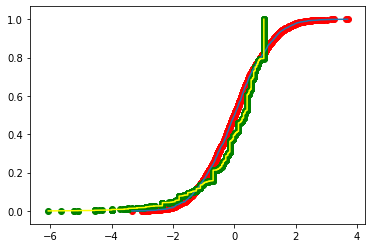

In [66]:
# generate a normal distribution with same length as 'mean_rating' for comparison
norm2 = nr.normal(size = len(mean_rating)).tolist()

# scale arrays
norm2_s = scale(norm2)
mean_rating_s = scale(mean_rating)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, mean_rating_s)

Perform a normality test using a comparison plot of cumulative distribution functions on log(*mean_rating*):

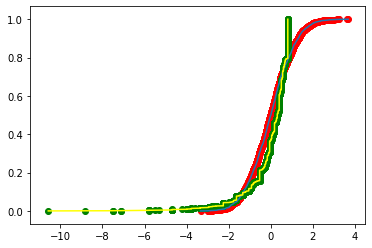

In [67]:
log_mean_rating_s = scale(log_mean_rating)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, log_mean_rating_s)

Neither *mean_rating* nor *log_mean_rating* fits the normal distribution according to comparison of its cumulative distribution function with that of normally-distributed data.

##### Formal Method: Kolmogorov-Smirnov Test

Now perform a formal test of normality, the Kolmogorov-Smirnov test, against *mean_rating*:

In [68]:
ks_test(mean_rating_s)

KS-statistic = 0.1685709267124783
P-value = 1.1091001847399089e-73


The K-S statistic is not small and the p-value is minuscule. The chance that we can safely reject the null hypothesis (the distribution is not normal) is quite low. The distribution is apparently not normal.

Now perform a formal test of normality, the Kolmogorov-Smirnov test, against *log_mean_rating*:

In [69]:
ks_test(log_mean_rating_s)

KS-statistic = 0.2079344443657335
P-value = 6.885581555278203e-112


Again, the K-S statistic is large and the p-value is minuscule, suggesting that the null hypothesis is correct, that the distribution is not normal.

### Create Categorical Variables

We create categorical variables for recipe components that may contribute to users' perception of the recipes and, hence, their ratings, in particular, the carbohydrate, fat, and sodium component of the recipes. We construct these variables by taking tertiles of the respective percentage content in grams of each component and defining categories according to these bins. We then consider whether there is any meaningful effect on user ratings between the bins.

#### The Carbohydrate Element: High-Carb, Medium-Carb, Low-Carb

We create three categories for carbohydrate content: high_carb, medium_carb, and low_carb:

In [70]:
# Use percentiles to bin into 3 categories
carb_pct = np.array(recipes['carbohydrates_pct'].values)
low_cutoff = np.percentile(carb_pct, 33)
mid_cutoff = np.percentile(carb_pct, 67)

# Set carb_level category by position in tertiles
carb_level = np.array([None] * len(carb_pct))
carb_level[carb_pct <= low_cutoff] = 'low_carb'
carb_level[carb_pct > low_cutoff] = 'medium_carb'
carb_level[carb_pct > mid_cutoff] = 'high_carb'
recipes['carb_level'] = carb_level

#### The Fat Element: High-Fat, Medium-Fat, Low-Fat

We create three categories for fat content: high_fat, medium_fat, and low_fat:

In [71]:
# Use percentiles to bin into 3 categories
fat_pct = np.array(recipes['total_fat_pct'].values)
low_cutoff = np.percentile(fat_pct, 33)
mid_cutoff = np.percentile(fat_pct, 67)

# Set fat_level category by position in tertiles
fat_level = np.array([None] * len(fat_pct))
fat_level[fat_pct <= low_cutoff] = 'low_fat'
fat_level[fat_pct > low_cutoff] = 'medium_fat'
fat_level[fat_pct > mid_cutoff] = 'high_fat'
recipes['fat_level'] = fat_level

#### The Sodium Element: High-Sodium, Medium-Sodium, Low-Sodium

We create three categories for sodium content: high_sodium, medium_sodium, and low_sodium:

In [72]:
# Use percentiles to bin into 3 categories
sodium_pct = np.array(recipes['sodium_pct'].values)
low_cutoff = np.percentile(sodium_pct, 33)
mid_cutoff = np.percentile(sodium_pct, 67)

# Set sodium_level category by position in tertiles
sodium_level = np.array([None] * len(sodium_pct))
sodium_level[sodium_pct <= low_cutoff] = 'low_sodium'
sodium_level[sodium_pct > low_cutoff] = 'medium_sodium'
sodium_level[sodium_pct > mid_cutoff] = 'high_sodium'
recipes['sodium_level'] = sodium_level

### Hypothesis Testing of Low and High Groups Using Classical Methods

Here we test for meaningful differences in mean_rating between low and high groups of the variables carb_level, fat_level, and sodium_level using classical methods (T-tests). (Note ANOVA and Tukey HSD are considered below where we compare multiple groups.)

#### Apply Classical Method to Carb Level

Test for a meaningful difference in user ratings between recipes with low vs. high carbs using a t-test and comparative histograms:

DegFreedom   1964.9826
Difference      0.0342
Statistic       1.2092
PValue          0.2267
Low95CI        -0.0213
High95CI        0.0898
dtype: float64


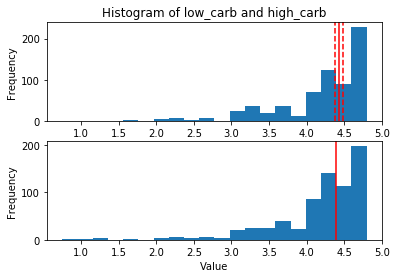

In [73]:
# Extract groups
low_carb = np.array(recipes.loc[recipes.loc[:, 'carb_level'] == 'low_carb', 'mean_rating'])
high_carb = np.array(recipes.loc[recipes.loc[:, 'carb_level'] == 'high_carb', 'mean_rating'])

# perform t-test
test_carb_level = t_test(low_carb, high_carb, alpha = 0.05)
print(test_carb_level)

# produce comparative plots
plot_t(low_carb, high_carb, test_carb_level, cols=['low_carb', 'high_carb'])

There does not appear to be a meaningful difference in user rating between low-carb and high-carb recipes. The difference in means is quite small suggesting that no real meaningful difference exists between groups. Meanwhile the t-statistic is low and the p-value is higher than we would expect if there were a meaningful difference. Note also that the 95% confidence interval straddles 0, indicating that the possibility that there is no difference lies within the confidence interval.

#### Apply Classical Method to Fat Level

Test for a meaningful difference in user ratings between recipes with low vs. high fat using a t-test and comparative histograms:

DegFreedom   1904.0336
Difference     -0.1328
Statistic      -4.8461
PValue          0.0000
Low95CI        -0.1866
High95CI       -0.0791
dtype: float64


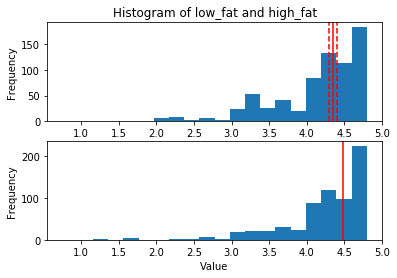

In [74]:
# Extract groups
low_fat = np.array(recipes.loc[recipes.loc[:, 'fat_level'] == 'low_fat', 'mean_rating'])
high_fat = np.array(recipes.loc[recipes.loc[:, 'fat_level'] == 'high_fat', 'mean_rating'])

# perform t-test
test_fat_level = t_test(low_fat, high_fat, alpha = 0.05)
print(test_fat_level)

# produce comparative plots
plot_t(low_fat, high_fat, test_fat_level, cols=['low_fat', 'high_fat'])

There appears to be a meaningful difference in user rating between low-fat and high-fat recipes. While the means appear numerically close at first glance, the p-value is extremely low and the 95% confidence interval does not straddle 0. The histograms show that the mean user rating of high-fat recipes lies outside the confidence interval of the mean of low-fat recipes.

#### Apply Classical Method to Sodium Level

Test for a meaningful difference in user ratings between recipes with low vs. high sodium using a t-test and comparative histograms:

DegFreedom   1938.9581
Difference      0.0697
Statistic       2.5091
PValue          0.0122
Low95CI         0.0152
High95CI        0.1242
dtype: float64


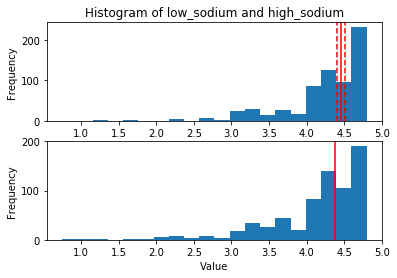

In [75]:
# Extract groups
low_sodium = np.array(recipes.loc[recipes.loc[:, 'sodium_level'] == 'low_sodium', 'mean_rating'])
high_sodium = np.array(recipes.loc[recipes.loc[:, 'sodium_level'] == 'high_sodium', 'mean_rating'])

# perform t-test
test_sodium_level = t_test(low_sodium, high_sodium, alpha = 0.05)
print(test_sodium_level)

# produce comparative plots
plot_t(low_sodium, high_sodium, test_sodium_level, cols=['low_sodium', 'high_sodium'])

There appears to be a meaningful difference in user rating between low-sodium and high-sodium recipes. While the means appear numerically close at first glance, the p-value is low and the 95% confidence interval does not straddle 0. The histograms show that the mean user rating of high-fat recipes lies slightly outside the confidence interval of the mean of low-fat recipes.

### Hypothesis Testing of Low and High Groups Using Bootstrap Sampling

Here we test for meaningful differences in *mean_rating* between low and high groups of the variables *carb_level*, *fat_level*, and *sodium_level* using bootstrap sampling.

#### Apply Bootstrap Sampling to Carb Level

Test for a meaningful difference in user ratings between recipes with low vs. high carbs using bootstrap sampling.

In [128]:
# Extract groups
low_carb = recipes[recipes.carb_level == 'low_carb']
high_carb = recipes[recipes.carb_level == 'high_carb']

len(low_carb), len(high_carb)

(987, 980)

Plot histograms of the two samples with means and confidence intervals:

Point estimate of the mean =   4.43
The lower and upper confidence intervals =   2.68   5.00 

Point estimate of the mean =   4.39
The lower and upper confidence intervals =   2.77   5.00 



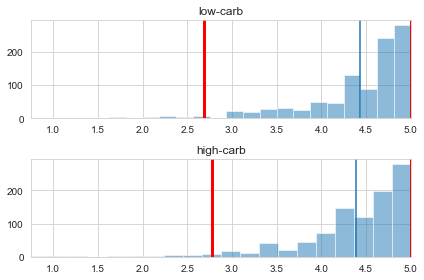

In [129]:
plot_dists(low_carb.mean_rating, high_carb.mean_rating, 20, 
           a_label='low-carb', b_label='high-carb')

The histograms suggest that there is no meaningful difference between low-carb and high-carb recipes in terms of user ratings. To confirm, we apply bootstrap sampling to compute the difference in means:

Point estimate of the mean =   0.03
The lower and upper confidence intervals =  -0.02   0.09 



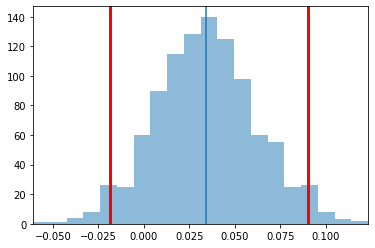

In [78]:
# Apply bootstrap sampling to compute the difference in means
diffs = []
n_replicas=1000
for i in range(n_replicas):
    sample = recipes.sample(frac=1.0, replace=True)
    low_carb_sample_mean = sample[sample.carb_level == 'low_carb'].mean_rating.mean()
    high_carb_sample_mean = sample[sample.carb_level == 'high_carb'].mean_rating.mean()
    diffs.append(low_carb_sample_mean - high_carb_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs, diffs.min(), diffs.max())

The values of the distribution of the difference are not far from zero, suggesting that we cannot infor that the means of the two populations are meaningfully different. At the same time, the confidence interval straddles zero, the point of no difference between means.

Now we determine whether the difference in means of low-carb and high-carb recipes is normal as expected under the Central Limit theorem by comparing the bootstrap distribution in means to normal:

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bootstrap mean (Carbohydrate Content)')

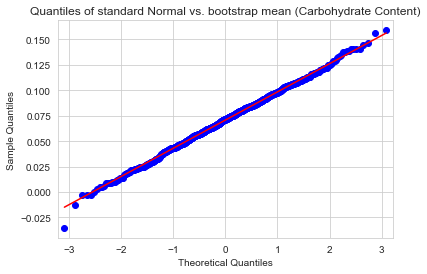

In [121]:
## Is the bootstrapped distribution normal?
fig = sm.qqplot(diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bootstrap mean (Carbohydrate Content)')

The distribution of the difference in means computed by the bootstrap method is normal as expected.

#### Apply Bootstrap Sampling to Fat Level

Test for a meaningful difference in user ratings between recipes with low vs. high fat using bootstrap sampling.

In [79]:
# Extract groups
low_fat = recipes[recipes.fat_level == 'low_fat']
high_fat = recipes[recipes.fat_level == 'high_fat']

len(low_fat), len(high_fat)

(980, 980)

Plot histograms of the two samples with means and confidence intervals:

Point estimate of the mean =   4.34
The lower and upper confidence intervals =   2.67   5.00 

Point estimate of the mean =   4.48
The lower and upper confidence intervals =   3.00   5.00 



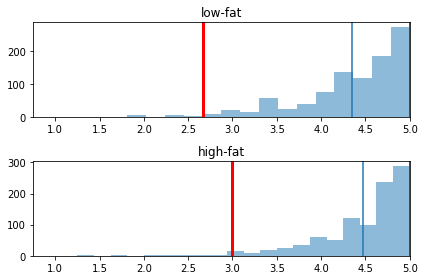

In [80]:
plot_dists(low_fat.mean_rating, high_fat.mean_rating, 20, a_label='low-fat', b_label='high-fat')

While the histograms suggest at first glance that there is little difference between low-fat and high-fat recipes in terms of user ratings, appearances may be deceiving due to the non-normality of the *mean_ratings* column (see above). Because ratings skew towards the high end (ratings tend to be favorable), it is possible that small differences in ratings reflect meaningful differences in user perception. To confirm, we apply bootstrap sampling to compute the difference in means:

Point estimate of the mean =   0.13
The lower and upper confidence intervals =   0.08   0.19 



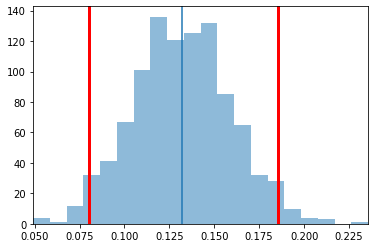

In [81]:
# Apply bootstrap sampling to compute the difference in means
diffs = []
n_replicas=1000
for i in range(n_replicas):
    sample = recipes.sample(frac=1.0, replace=True)
    low_fat_sample_mean = sample[sample.fat_level == 'low_fat'].mean_rating.mean()
    high_fat_sample_mean = sample[sample.fat_level == 'high_fat'].mean_rating.mean()
    diffs.append(high_fat_sample_mean - low_fat_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs, diffs.min(), diffs.max())

The values of the distribution of the difference in means is not far from zero, yet the fact that the confidence interval does not straddle zero (no difference) suggests that there may be a meaningful difference between the low-fat and high-fat groups. If this is the case, the proximity of the difference in means is a side effect of the non-normal distribution in which ratings tend to skew towards the high end of favorability due to the social dynamics of the web-based community that supplies the ratings data.

Now we determine whether the difference in means of low-fat and high-fat recipes is normal as expected under the Central Limit theorem by comparing the bootstrap distribution in means to normal:

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bootstrap mean (Fat Content)')

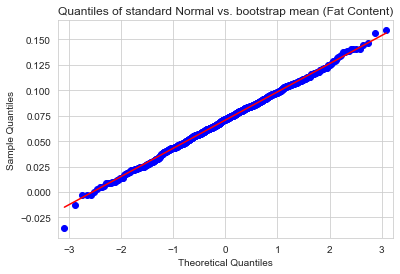

In [122]:
## Is the bootstrapped distribution normal?
fig = sm.qqplot(diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bootstrap mean (Fat Content)')

The distribution of the difference in means computed by the bootstrap method is normal as expected.

#### Apply Bootstrap Sampling to Sodium Level

Test for a meaningful difference in user ratings between recipes with low vs. high sodium using bootstrap sampling.

In [124]:
# Extract groups
low_sodium = recipes[recipes.sodium_level == 'low_sodium']
high_sodium = recipes[recipes.sodium_level == 'high_sodium']

len(low_sodium), len(high_sodium)

(980, 980)

Plot histograms of the two samples with means and confidence intervals:

Point estimate of the mean =   4.45
The lower and upper confidence intervals =   3.00   5.00 

Point estimate of the mean =   4.38
The lower and upper confidence intervals =   2.67   5.00 



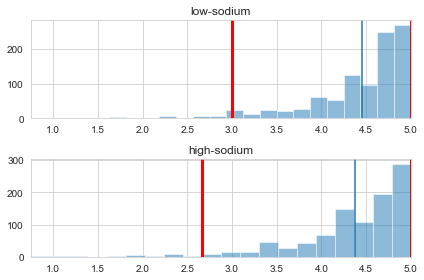

In [126]:
plot_dists(low_sodium.mean_rating, high_sodium.mean_rating, 20, 
           a_label='low-sodium', b_label='high-sodium')

While the histograms suggest at first glance that there is little difference between low-sodium and high-sodium recipes in terms of user ratings, appearances may be deceiving due to the non-normality of the *mean_ratings* column (see above). Because ratings skew towards the high end (ratings tend to be favorable), it is possible that small differences in ratings reflect meaningful differences in user perception. To confirm, we apply bootstrap sampling to compute the difference in means:

Point estimate of the mean =   0.07
The lower and upper confidence intervals =   0.02   0.12 



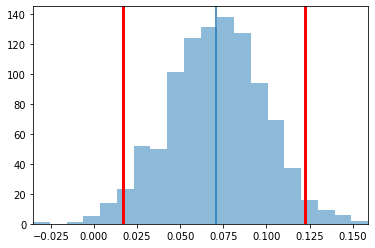

In [84]:
# Apply bootstrap sampling to compute the difference in means
diffs = []
n_replicas=1000
for i in range(n_replicas):
    sample = recipes.sample(frac=1.0, replace=True)
    low_sodium_sample_mean = sample[sample.sodium_level == 'low_sodium'].mean_rating.mean()
    high_sodium_sample_mean = sample[sample.sodium_level == 'high_sodium'].mean_rating.mean()
    diffs.append(low_sodium_sample_mean - high_sodium_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs, diffs.min(), diffs.max())

Again, the values of the distribution of the difference in means is not far from zero, yet the fact that the confidence interval does not straddle zero (no difference) suggests that there may be a meaningful difference between the low-sodium and high-sodium groups. As noted above, if this is the case, the proximity of the difference in means is a side effect of the non-normal distribution in which ratings tend to skew towards the high end of favorability due to the social dynamics of the web-based community that supplies the ratings data.

Now we determine whether the difference in means of low-sodium and high-sodium recipes is normal as expected under the Central Limit theorem by comparing the bootstrap distribution in means to normal:

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bootstrap mean (Sodium Content)')

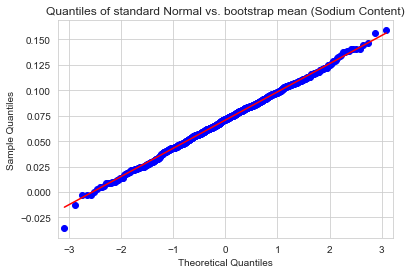

In [130]:
## Is the bootstrapped distribution normal?
fig = sm.qqplot(diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bootstrap mean (Sodium Content)')

The distribution of the difference in means computed by the bootstrap method is normal as expected.

### Hypothesis Testing of Low and High Groups Using Bayesian Models

Here we test for meaningful differences in *mean_rating* between low and high groups of the variables *carb_level*, *fat_level*, and *sodium_level* using Bayesian models.

#### Apply Bayesian Models to Carb Level

Test for a meaningful difference in user ratings between recipes with low vs. high carbs using Bayesian models.

In [85]:
# Extract groups
num_samples = 100
low_carb = recipes[recipes.carb_level == 'low_carb'].sample(n=num_samples)
high_carb = recipes[recipes.carb_level == 'high_carb'].sample(n=num_samples)

Plot histogram of user ratings of the two groups:

Text(0.5, 1.0, 'Histograms of user ratings of recipes')

Text(0.5, 0, 'Mean Rating')

Mean of low-carb user ratings: 4.42
Mean of high-carb user ratings: 4.31


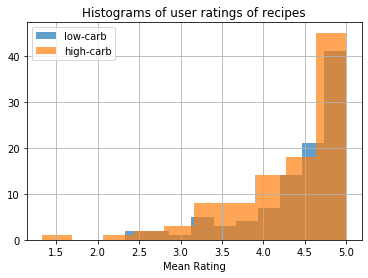

In [86]:
plt.title('Histograms of user ratings of recipes')
low_carb.mean_rating.hist(label='low-carb', bins=10, alpha=.7)
high_carb.mean_rating.hist(label='high-carb', bins=10, alpha=.7)
plt.xlabel('Mean Rating')
plt.legend()

mean_low_carb_rating = low_carb.mean_rating.mean()
mean_high_carb_rating = high_carb.mean_rating.mean()
print('Mean of low-carb user ratings: %.2f' % mean_low_carb_rating)
print('Mean of high-carb user ratings: %.2f' % mean_high_carb_rating)

The histogram reveals some potentially interesting differences in the distribution of user ratings between the two groups. Particularly striking is the spike in low-carb recipes with the highest rating. To determine whether these differences are significant, we turn to a comparison of means and confidence intervals.

Estimate the posterior distribution of the mean user rating for low-carb recipes:

Mean = 4.419, Standard deviation = 0.636


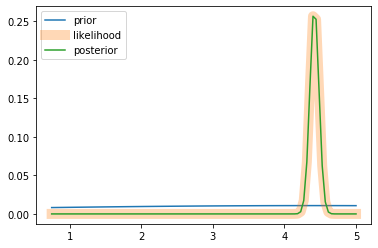

In [87]:
N = len(low_carb)
p = np.linspace(0.75, 5, num=N)

pp_low_carb = ss.norm.pdf(p, loc=low_carb.mean_rating.mean(), scale=5)
pp_low_carb = pp_low_carb / pp_low_carb.sum() # normalize

like_low_carb = comp_like(p, low_carb.mean_rating)
post_low_carb = posterior(pp_low_carb, like_low_carb)

plt.plot(p, pp_low_carb, label='prior')
plt.plot(p, like_low_carb, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_low_carb, label='posterior')
_=plt.legend()

Estimate the posterior distribution of the mean user rating for high-carb recipes:

Mean = 4.308, Standard deviation = 0.716


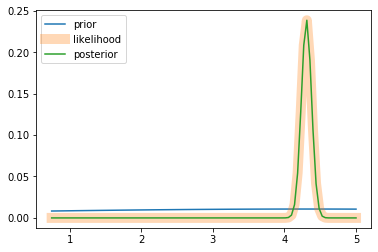

In [88]:
pp_high_carb = ss.norm.pdf(p, loc=high_carb.mean_rating.mean(), scale=5)
pp_high_carb = pp_high_carb / pp_high_carb.sum() # normalize

like_high_carb = comp_like(p, high_carb.mean_rating)
post_high_carb = posterior(pp_high_carb, like_high_carb)

plt.plot(p, pp_high_carb, label='prior')
plt.plot(p, like_high_carb, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_high_carb, label='posterior')
plt.legend()

Now compare the posterior distribution of the mean user rating of low-carb recipes to the distribution of the mean user rating of high-carb recipes. Compute the mean user rating and confidence interval for the low-carb group:

The 0.950 credible interval is 4.313 to 4.528


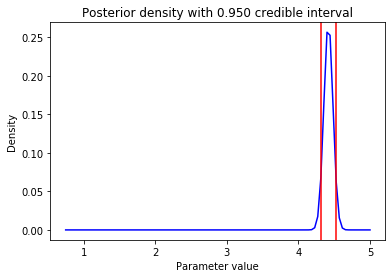

In [89]:
num_samples = 100000
plot_ci(p, post_low_carb, num_samples, lower_q=.025, upper_q=.975)

Compute the mean user rating and confidence interval for the high-carb group:

The 0.950 credible interval is 4.184 to 4.442


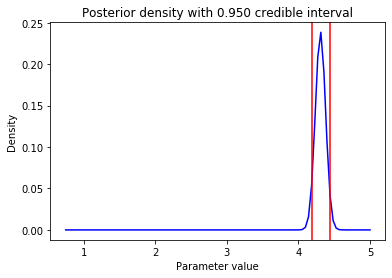

In [90]:
plot_ci(p, post_high_carb, num_samples, lower_q=.025, upper_q=.975)

The confidence intervals between the groups overlap suggesting that there is no meaningful difference in user ratings of recipes based on carb content.

#### Apply Bayesian Models to Fat Level

Test for a meaningful difference in user ratings between recipes with low vs. high fat using Bayesian models.

In [91]:
# Extract groups
num_samples = 100
low_fat = recipes[recipes.fat_level == 'low_fat'].sample(n=num_samples)
high_fat = recipes[recipes.fat_level == 'high_fat'].sample(n=num_samples)

Plot histogram of user ratings of the two groups:

Text(0.5, 1.0, 'Histograms of user ratings of recipes')

Text(0.5, 0, 'Mean Rating')

Mean of low-fat user ratings: 4.27
Mean of high-fat user ratings: 4.53


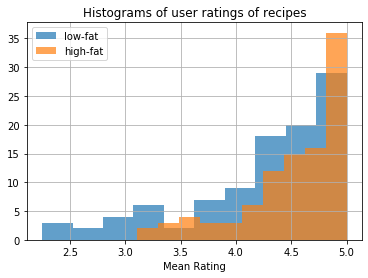

In [92]:
plt.title('Histograms of user ratings of recipes')
low_fat.mean_rating.hist(label='low-fat', bins=10, alpha=.7)
high_fat.mean_rating.hist(label='high-fat', bins=10, alpha=.7)
plt.xlabel('Mean Rating')
plt.legend()
mean_low_fat_rating = low_fat.mean_rating.mean()
mean_high_fat_rating = high_fat.mean_rating.mean()
print('Mean of low-fat user ratings: %.2f' % mean_low_fat_rating)
print('Mean of high-fat user ratings: %.2f' % mean_high_fat_rating)

The histogram suggests that recipes with higher fat lean towards the high end of the ratings scale in comparison with lower fat recipes. To determine whether this is significant, we turn to a comparison of means and confidence intervals.

Estimate the posterior distribution of the mean user rating for low-fat recipes:

Mean = 4.268, Standard deviation = 0.688


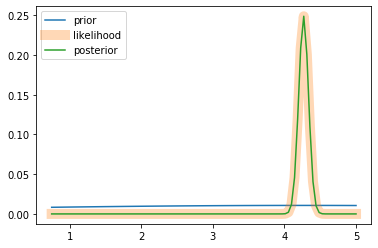

In [93]:
N = len(low_fat)
p = np.linspace(0.75, 5, num=N)

pp_low_fat = ss.norm.pdf(p, loc=low_fat.mean_rating.mean(), scale=5)
pp_low_fat = pp_low_fat / pp_low_fat.sum() # normalize

like_low_fat = comp_like(p, low_fat.mean_rating)
post_low_fat = posterior(pp_low_fat, like_low_fat)

plt.plot(p, pp_low_fat, label='prior')
plt.plot(p, like_low_fat, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_low_fat, label='posterior')
_=plt.legend()

Estimate the posterior distribution of the mean user rating for high-fat recipes:

Mean = 4.533, Standard deviation = 0.477


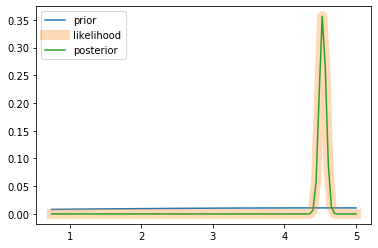

In [94]:
pp_high_fat = ss.norm.pdf(p, loc=high_fat.mean_rating.mean(), scale=5)
pp_high_fat = pp_high_fat / pp_high_fat.sum() # normalize

like_high_fat = comp_like(p, high_fat.mean_rating)
post_high_fat = posterior(pp_high_fat, like_high_fat)

plt.plot(p, pp_high_fat, label='prior')
plt.plot(p, like_high_fat, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_high_fat, label='posterior')
plt.legend()

Now compare the posterior distribution of the mean user rating of low-fat recipes to the distribution of the mean user rating of high-fat recipes. Compute the mean user rating and confidence interval for the low-fat group:

The 0.950 credible interval is 4.141 to 4.399


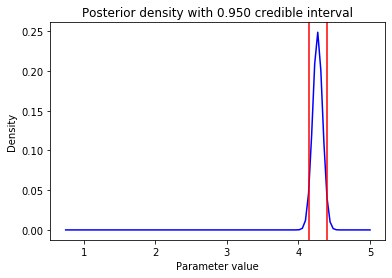

In [95]:
num_samples = 100000

plot_ci(p, post_low_fat, num_samples, lower_q=.025, upper_q=.975)

Compute the mean user rating and confidence interval for the high-fat group:

The 0.950 credible interval is 4.442 to 4.614


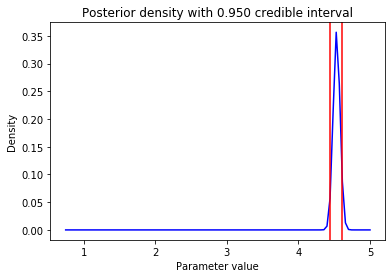

In [96]:
plot_ci(p, post_high_fat, num_samples, lower_q=.025, upper_q=.975)

According to our Bayesian model, the difference in mean user rating between low-fat recipes and high-fat recipes is likely to be meaningful because the credible intervals of the means do not overlap.

#### Apply Bayesian Models to Sodium Level

Test for a meaningful difference in user ratings between recipes with low vs. high sodium using Bayesian models.

In [97]:
# Extract groups
num_samples = 100
low_sodium = recipes[recipes.sodium_level == 'low_sodium'].sample(n=num_samples)
high_sodium = recipes[recipes.sodium_level == 'high_sodium'].sample(n=num_samples)

Plot histogram of user ratings of the two groups:

Text(0.5, 1.0, 'Histograms of user ratings of recipes')

Text(0.5, 0, 'Mean Rating')

Mean of low-sodium user ratings: 4.45
Mean of high-sodium user ratings: 4.42


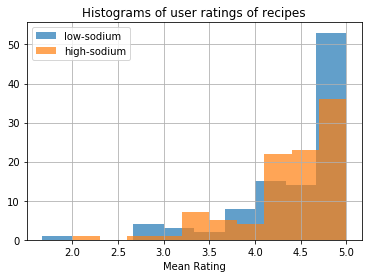

In [98]:
plt.title('Histograms of user ratings of recipes')
low_sodium.mean_rating.hist(label='low-sodium', bins=10, alpha=.7)
high_sodium.mean_rating.hist(label='high-sodium', bins=10, alpha=.7)
plt.xlabel('Mean Rating')
plt.legend()

mean_low_sodium_rating = low_sodium.mean_rating.mean()
mean_high_sodium_rating = high_sodium.mean_rating.mean()
print('Mean of low-sodium user ratings: %.2f' % mean_low_sodium_rating)
print('Mean of high-sodium user ratings: %.2f' % mean_high_sodium_rating)

The histogram reveals an apparently negligible difference in distribution of user ratings between the two groups.

Estimate the posterior distribution of the mean user rating for low-sodium recipes:

Mean = 4.454, Standard deviation = 0.582


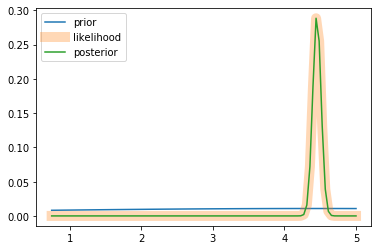

In [99]:
N = len(low_sodium)
p = np.linspace(0.75, 5, num=N)

pp_low_sodium = ss.norm.pdf(p, loc=low_sodium.mean_rating.mean(), scale=5)
pp_low_sodium = pp_low_sodium / pp_low_sodium.sum() # normalize

like_low_sodium = comp_like(p, low_sodium.mean_rating)
post_low_sodium = posterior(pp_low_sodium, like_low_sodium)

plt.plot(p, pp_low_sodium, label='prior')
plt.plot(p, like_low_sodium, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_low_sodium, label='posterior')
_=plt.legend()

Estimate the posterior distribution of the mean user rating for high-sodium recipes:

Mean = 4.416, Standard deviation = 0.586


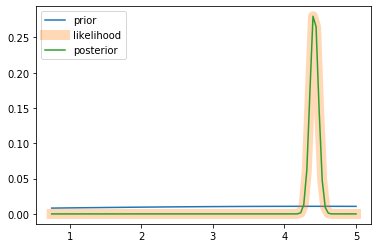

In [100]:
pp_high_sodium = ss.norm.pdf(p, loc=high_sodium.mean_rating.mean(), scale=5)
pp_high_sodium = pp_high_sodium / pp_high_sodium.sum() # normalize

like_high_sodium = comp_like(p, high_sodium.mean_rating)
post_high_sodium = posterior(pp_high_sodium, like_high_sodium)

plt.plot(p, pp_high_sodium, label='prior')
plt.plot(p, like_high_sodium, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_high_sodium, label='posterior')
plt.legend()

Now compare the posterior distribution of the mean user rating of low-sodium recipes to the distribution of the mean user rating of high-sodium recipes. Compute the mean user rating and confidence interval for the low-sodium group:

The 0.950 credible interval is 4.356 to 4.571


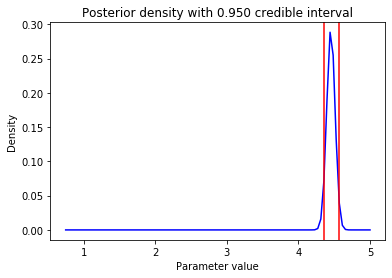

In [101]:
num_samples = 100000

plot_ci(p, post_low_sodium, num_samples, lower_q=.025, upper_q=.975)

Compute the mean user rating and confidence interval for the high-sodium group:

The 0.950 credible interval is 4.313 to 4.528


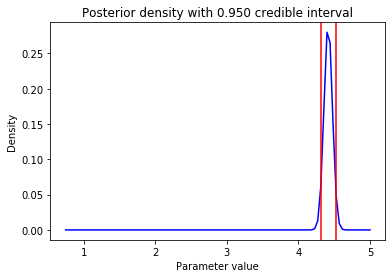

In [102]:
plot_ci(p, post_high_sodium, num_samples, lower_q=.025, upper_q=.975)

According to our Bayesian model, the difference in mean user rating between low-sodium recipes and high-sodium recipes is not meaningful because the credible intervals of the means overlap.

### Hypothesis Testing of Three Groups: ANOVA and Tukey's HSD Test

#### High-Carb, Medium-Carb, Low-Carb

We now test whether high-carb vs. low-carb recipes have a meaningful difference in ratings. We use the categorical variable *carb_level* created by binning the numeric variable *carbohydrates_pct*, which represents the percent of carbohydrates per recipe by mass relative to the mass of a serving:

##### Apply ANOVA and Tukey's HSD Test to Mean Rating by Carb Level

We now apply ANOVA and Tukey's HSD test to categories of carb level by mean rating:

In [103]:
# extract groups
low_carb = np.array(recipes.loc[recipes.loc[:, 'carb_level'] == 'low_carb', 'mean_rating'])
medium_carb = np.array(recipes.loc[recipes.loc[:, 'carb_level'] == 'medium_carb', 'mean_rating'])
high_carb = np.array(recipes.loc[recipes.loc[:, 'carb_level'] == 'high_carb', 'mean_rating'])

# prepare dataframe
df = pd.DataFrame({'vals': low_carb.tolist() + medium_carb.tolist() + high_carb.tolist(),
                   'group': ['low_carb'] * len(low_carb) + ['medium_carb'] * len(medium_carb) +
                  ['high_carb'] * len(high_carb)})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group)
print(Tukey_HSD)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
high_carb    low_carb   0.0342 0.4233 -0.0298 0.0982  False
high_carb medium_carb   0.0432 0.2516 -0.0206  0.107  False
 low_carb medium_carb   0.0089    0.9 -0.0547 0.0726  False
-----------------------------------------------------------


We can visualize the groups graphically:

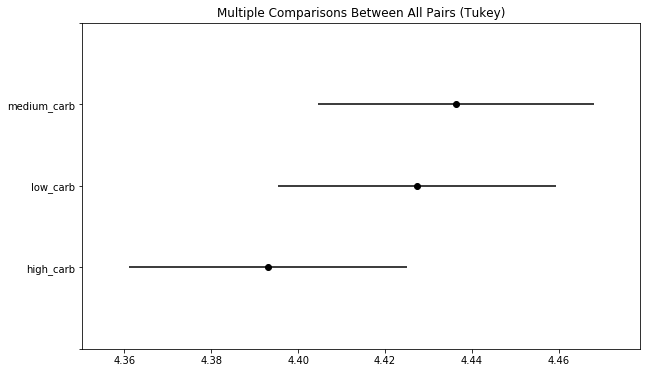

In [104]:
_ = Tukey_HSD.plot_simultaneous()

The test indicates that there is no clear meaningful difference in mean user rating between the categories of recipes based on level of carbohydrates (reject null hypothesis == False). In the case of all three relationships the test recommends that we do not reject the null hypothesis. The confidence interval straddles zero (no difference) between each of the respective pairs of categories, suggesting that we can have no confidence in any difference between the groups. Meanwhile, the p-values are quite high for each of the three relationships. Finally, we observe significant overlap in the simultaneous plot between all three categories. While we might expect high-carb recipes to be more popular than recipes with fewer carbs, this is not the case based on analysis of our data.

#### High-Fat, Medium-Fat, Low-Fat

Our next test is whether high-fat vs. low-fat recipes have a meaningful difference in ratings. We use the categorical variable *fat_level* created by binning the numeric variable *total_fat_pct*, which represents the percent of fat per recipe by mass relative to the mass of a serving:

##### Apply ANOVA and Tukey's HSD Test to Mean Rating by Total Fat Level

We now apply ANOVA and Tukey's HSD test to categories of total fat level by mean rating:

In [105]:
# extract groups
low_fat = np.array(recipes.loc[recipes.loc[:, 'fat_level'] == 'low_fat', 'mean_rating'])
medium_fat = np.array(recipes.loc[recipes.loc[:, 'fat_level'] == 'medium_fat', 'mean_rating'])
high_fat = np.array(recipes.loc[recipes.loc[:, 'fat_level'] == 'high_fat', 'mean_rating'])

# prepare dataframe
df = pd.DataFrame({'vals': low_fat.tolist() + medium_fat.tolist() + high_fat.tolist(),
                   'group': ['low_fat'] * len(low_fat) + ['medium_fat'] * len(medium_fat) +
                  ['high_fat'] * len(high_fat)})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group)
print(Tukey_HSD)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2   meandiff p-adj   lower  upper  reject
---------------------------------------------------------
high_fat    low_fat  -0.1328  0.001 -0.1967 -0.069   True
high_fat medium_fat  -0.0433 0.2451 -0.1068 0.0201  False
 low_fat medium_fat   0.0895 0.0027  0.0261 0.1529   True
---------------------------------------------------------


We can visualize the groups graphically:

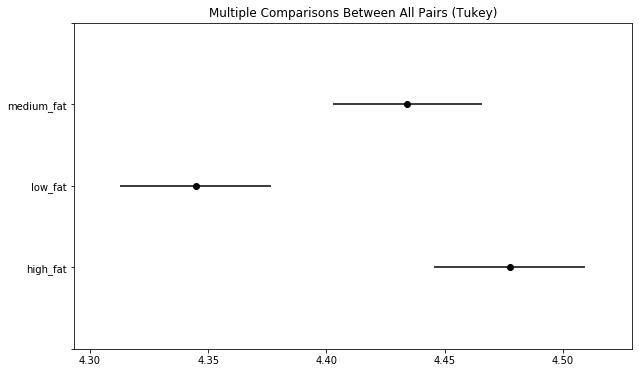

In [106]:
_ = Tukey_HSD.plot_simultaneous()

The test indicates that there is no clear meaningful difference in mean user rating between recipes with medium and high fat, but a potentially meaningful difference between recipes with low fat and recipes with medium or high fat. Between medium-fat and high-fat recipes the confidence interval straddles zero, suggesting that there is no meaningful difference between medium-fat and high-fat recipes in terms of user ratings. On the other hand, the respective confidence intervals between these two categories and low-fat recipes do not straddle zero, suggesting that there is a meaningful difference in user ratings between low-fat recipes and recipes with higher fat content, with users preferring the latter. Similarly, the p-value between medium- and high-fat recipes is high, but low between these categores and low-fat recipes. Finally, we observe significant overlap between medium- and high-fat recipes, but no overlap between these categories and low-fat recipes in the simultaneous plot between all three categories. So there is a meaningful difference in user ratings between low-fat recipes, which users tend to prefer less, and recipes with higher fat.

#### High-Sodium, Medium-Sodium, Low-Sodium

Our next test is whether high-sodium vs. low-sodium recipes have a meaningful difference in ratings. We use the categorical variable *sodium_level* created by binning the numeric variable *total_sodium_pct*, which represents the percent of sodium per recipe by mass relative to the mass of a serving:

##### Apply ANOVA and Tukey's HSD Test to Mean Rating by Sodium Level

We now apply ANOVA and Tukey's HSD test to categories of sodium level by mean rating:

In [107]:
# extract groups
low_sodium = np.array(recipes.loc[recipes.loc[:, 'sodium_level'] == 'low_sodium', 'mean_rating'])
medium_sodium = np.array(recipes.loc[recipes.loc[:, 'sodium_level'] == 'medium_sodium', 'mean_rating'])
high_sodium = np.array(recipes.loc[recipes.loc[:, 'sodium_level'] == 'high_sodium', 'mean_rating'])

# prepare dataframe
df = pd.DataFrame({'vals': low_sodium.tolist() + medium_sodium.tolist() + high_sodium.tolist(),
                   'group': ['low_sodium'] * len(low_sodium) + ['medium_sodium'] * len(medium_sodium) +
                  ['high_sodium'] * len(high_sodium)})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group)
print(Tukey_HSD)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
high_sodium    low_sodium   0.0697 0.0291  0.0056 0.1338   True
high_sodium medium_sodium   0.0416  0.276  -0.022 0.1052  False
 low_sodium medium_sodium  -0.0281  0.551 -0.0917 0.0355  False
---------------------------------------------------------------


We can visualize the groups graphically:

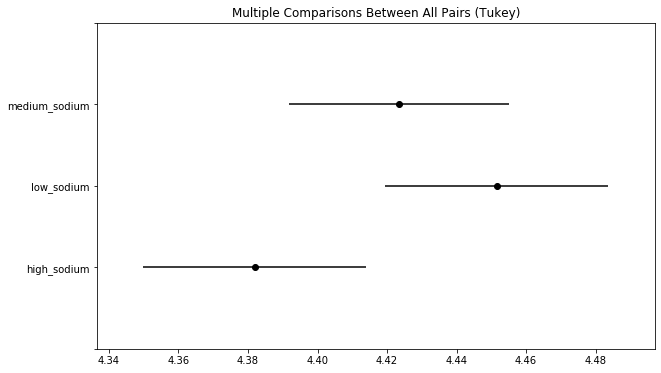

In [108]:
_ = Tukey_HSD.plot_simultaneous()

The test indicates that there is no clear meaningful difference in mean user rating between recipes with low and medium sodium, but a potentially meaningful difference between recipes with high sodium and recipes with low or medium fat. Between low-sodium and medium-sodium recipes the confidence interval straddles zero, suggesting that there is no meaningful difference between low-sodium and medium-sodium recipes in terms of user ratings. On the other hand, the respective confidence intervals between these two categories and high-sodium recipes do not straddle zero, suggesting that there is a meaningful difference in user ratings between high-sodium recipes and recipes with lower sodium content, with users preferring the latter. Similarly, the p-value between low- and medium-sodium recipes is high, but low between these categores and high-sodium recipes. Finally, we observe significant overlap between low- and medium-sodium recipes, but no overlap between these categories and high-sodium recipes in the simultaneous plot between all three categories. So there is a meaningful difference in user ratings between high-sodium recipes and recipes with lower sodium, which (surprisingly) users tend to prefer more.

TODO: Hypothesis testing performed appropriate to the question being addressed.

TODO: compute basic summary statistics by both classical, bootstrap, and Bayesian methods.

TODO: use confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant, i.e. compute confidence intervals for the above summary statistics by classical, bootstrap, and Bayesian methods.

### Conclusion

The question that we set out to answer is whether it is possible to predict the success of a recipe measured in terms of user ratings based on its contents. In the present analysis we examined three components: carbohydrate content, fat content, and sodium content. While carbohydrate content does not appear to be a meaningful predictor of user ratings, both fat content and sodium content appear to have some meaningful correlation with user ratings. Recipes with high fat content appear to be more popular than recipes with low fat. Somewhat surprisingly, recipes with *low* sodium content appear to be more popular than recipes high in sodium.

According to classical T-tests, the mean for high-carb recipes falls within the confidence interval of the mean for low-carb recipes, suggesting that carbohydrate content is not a meaningful predictor of user ratings. On the other hand, the means for both high-fat and high-sodium recipes fall outside the confidence interval of the means for low-fat and low-sodium recipes respectively, suggesting that both fat and sodium content are meaningful predictors of the success of a recipe.

According to the bootstrap sampling method, the difference in mean user rating between high-carb and low-carb recipes is close to zero while the confidence interval straddles zero, suggesting that no meaningful difference in user ratings exists between these groups. On the other hand, the mean user ratings between both high-fat and low-fat and high-sodium and low-sodium recipes in the bootstrap samples in neither case straddle the confidence intervals of these respective means, suggesting that fat content and sodium content are both meaningful predictors of user ratings.

According to the Bayesian method, the confidence intervals between the mean user ratings of high-carb and low-carb recipes overlap suggesting again that there is no meaningful difference between these groups. On the other hand, in neither case do the confidence intervals of the mean user ratings between high-fat and low-fat recipes or high-sodium and low-sodium recipes overlap suggesting that the differences in means between these groups are meaningful and, hence, that fat content and sodium content are useful predictors of user ratings.

According to our comparison of multiple groups, based on ANOVA and Tukey HSD, there is no meaningful difference in means between low-, medium-, and high-carb recipes as to user ratings, given that the confidence intervals of the means entirely overlap. On the other hand, the confidence intervals of the mean for low-fat recipes does not overlap the respective confidence intervals of either medium- or high-fat recipes, suggesting that low-fat recipes are less likely to receive positive user ratings than either medium- or high-fat recipes. Similarly, the confidence intervals of the mean for low-sodium and high-sodium recipes do not overlap, suggesting that high-sodium recipes are less likely to receive positive user ratings than low-sodium recipes.

Despite the non-normal distribution of user ratings and hence the small numeric differences in values between groups, which we have attributed to user bias towards more favorable ratings on the food.com web site, hypothesis testing suggests that certain features, in particular, fat content and sodium content, are meaningfully predictive of the success of a recipe as measured by user ratings.